# 付録B ロジスティック回帰上のトンプソン抽出

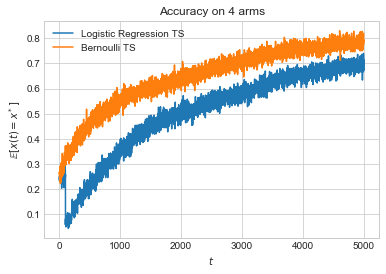

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

plt.style.use('seaborn-whitegrid')
np.random.seed(0)

# 環境クラスの設定
arms = [[0, 0], [0, 1], [1, 0], [1, 1]]

logistic = lambda x: 0 if x < -500 else 1 / (1 + np.exp(-x))
n_arms = len(arms)

class Env:
    def p(arm):
        p = logistic(arm[0] * 0.2 + arm[1] * 0.8 - 4 - (arm[2] * 0.5 if len(arm) > 2 else 0))
        return p

    def react(arm):
        return 1 if np.random.random() < Env.p(arm) else 0
    
    def opt():
        return np.argmax([Env.p(arm) for arm in arms])

# 特徴量を考慮しない通常のトンプソン抽出
class BernoulliTSAgent:
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.wins = [0 for _ in range(n_arms)]
    
    def get_arm(self):
        beta = lambda N, a: np.random.beta(a + 1, N - a + 1)
        result = [beta(self.counts[i], self.wins[i]) for i in range(n_arms)]
        arm = result.index(max(result))
        return arm
        
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.wins[arm] += reward

# ロジスティック回帰上のトンプソン抽出
class LogisticRegressionTSAgent:
    def __init__(self):
        self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T
        self.sigma = 1
        self.hatw = np.zeros((self.phis.shape[0], 1))
        self.invH = None
        self.selected_arms = []
        self.rewards = []
    
    def get_arm(self):
        if (len(self.selected_arms) % 100 == 0): self.update()
        w = np.random.multivariate_normal(self.hatw[:, 0], self.invH)
        est = self.phis.T.dot(w)
        return np.argmax(est)
        
    def update(self):
        for i in range(10):
            g = self.get_g()
            self.invH = self.get_invH()
            diff = self.invH.dot(g)
            self.hatw = self.hatw - diff
            if (np.linalg.norm(diff) < 0.0001): break
    
    def get_g(self):
        g = self.hatw / (self.sigma ** 2)
        for t, arm in enumerate(self.selected_arms):
            phi = self.phis[:, [arm]]
            g += phi * (logistic(phi.T.dot(self.hatw)) - self.rewards[t])
        return g
    
    def get_invH(self):
        H = np.identity(self.phis.shape[0]) / (self.sigma ** 2)
        for arm in self.selected_arms:
            phi = self.phis[:, [arm]]
            lpw = logistic(phi.T.dot(self.hatw))
            H += phi.dot(phi.T) * lpw * (1 - lpw)
        invH = np.linalg.inv(H)
        return invH
    
    def sample(self, arm_index, reward):
        self.selected_arms.append(arm_index)
        self.rewards.append(reward)

# シミュレーションの実行
n_step = 5000

def sim(Agent):
    agent = Agent()
    selected_arms = []
    earned_rewards = []
    for step in range(n_step):
        arm_index = agent.get_arm()
        reward = Env.react(arms[arm_index])
        agent.sample(arm_index, reward)
        selected_arms.append(arm_index)
        earned_rewards.append(reward)
    return (selected_arms, earned_rewards)

n_iter = 500
results = Parallel(n_jobs=-1)([delayed(sim)(LogisticRegressionTSAgent) for _ in range(n_iter)])
selected_arms_lr = np.array([i[0] for i in results])
earned_rewards_lr = np.array([i[1] for i in results])
results = Parallel(n_jobs=-1)([delayed(sim)(BernoulliTSAgent) for _ in range(n_iter)])
selected_arms_ber = np.array([i[0] for i in results])
earned_rewards_ber = np.array([i[1] for i in results])

plt.plot(np.mean(selected_arms_lr==Env.opt(), axis=0), label='Logistic Regression TS')
plt.plot(np.mean(selected_arms_ber==Env.opt(), axis=0),label='Bernoulli TS')
plt.title('Accuracy on %d arms' % (n_arms))
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

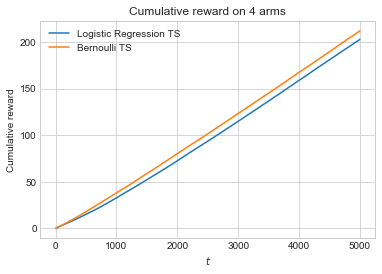

In [2]:
plt.plot(np.mean(np.cumsum(earned_rewards_lr, axis=1), axis=0), label='Logistic Regression TS')
plt.plot(np.mean(np.cumsum(earned_rewards_ber, axis=1), axis=0), label='Bernoulli TS')
plt.title('Cumulative reward on %d arms' % (n_arms))
plt.xlabel(r'$t$')
plt.ylabel('Cumulative reward')
plt.legend()
plt.show()

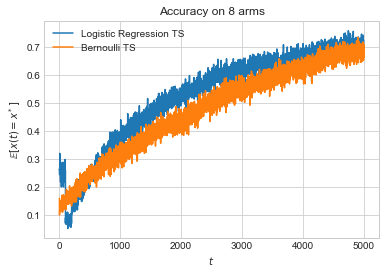

In [7]:
# 選択肢の数をさらに増やした場合
import itertools
arms = list(itertools.product([0, 1], [0, 1], [0, 1]))
n_arms = len(arms)

results = Parallel(n_jobs=-1)([delayed(sim)(LogisticRegressionTSAgent) for _ in range(n_iter)])
selected_arms_lr = np.array([i[0] for i in results])
earned_rewards_lr = np.array([i[1] for i in results])

results = Parallel(n_jobs=-1)([delayed(sim)(BernoulliTSAgent) for _ in range(n_iter)])
selected_arms_ber = np.array([i[0] for i in results])
earned_rewards_ber = np.array([i[1] for i in results])

plt.plot(np.mean(selected_arms_lr==Env.opt(), axis=0), label='Logistic Regression TS')
plt.plot(np.mean(selected_arms_ber==Env.opt(), axis=0), label='Bernoulli TS')
plt.title('Accuracy on %d arms' % (n_arms))
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

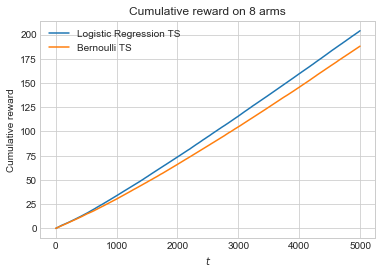

In [8]:
plt.plot(np.mean(np.cumsum(earned_rewards_lr, axis=1), axis=0), label='Logistic Regression TS')
plt.plot(np.mean(np.cumsum(earned_rewards_ber, axis=1), axis=0), label='Bernoulli TS')
plt.title('Cumulative reward on %d arms' % (n_arms))
plt.xlabel(r'$t$')
plt.ylabel('Cumulative reward')
plt.legend()
plt.show()